<a href="https://colab.research.google.com/github/elisasanzani/Software_and_Computing_Project/blob/main/XGBoost_RadiativeMuonCapture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Preliminary setup
import numpy as np
import os
import xgboost as xgb
import time

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split

np.random.seed() # shuffle random seed generator

!nvidia-smi

Tue Aug  9 17:17:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |    286MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Import data from GitHub
!wget https://www.dropbox.com/s/fqxxodsx3xpe9ge/mnbs_etrn.npy?dl=1 -O bkg_etrn.npy

!wget https://www.dropbox.com/s/bto89w1z2knnak7/signal_etrn.npy?dl=1 -O signal_etrn.npy

#!wget https://github.com/elisasanzani/Software_and_Computing_Project/raw/main/data/mnbs_etrn.npy -O bkg_etrn.npy
#!wget https://github.com/elisasanzani/Software_and_Computing_Project/raw/main/data/signal_etrn.npy -O signal_etrn.npy

--2022-08-09 17:18:01--  https://www.dropbox.com/s/fqxxodsx3xpe9ge/mnbs_etrn.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/fqxxodsx3xpe9ge/mnbs_etrn.npy [following]
--2022-08-09 17:18:02--  https://www.dropbox.com/s/dl/fqxxodsx3xpe9ge/mnbs_etrn.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdedbefba1783e3ba8b1ec55436.dl.dropboxusercontent.com/cd/0/get/BqvGnq6mmmuF9G3o-xBOgD0b-Wpg6tDAjOEjVe0TzREpaMZzgQm_DiOIef-Xkyq6qUxdjBD1HgCyeJPHb4XAxSOPgfnfpJZBY9gziOpBiG5QSdKp3OJLs4i7P-UF9KlNI5IfF5fdAxIz0POo-peDSdtDcerzSHQwL3NZbL6kt3xG7uO-Higzop7f5nhDUtnlI04/file?dl=1# [following]
--2022-08-09 17:18:02--  https://ucdedbefba1783e3ba8b1ec55436.dl.dropboxusercontent.com/cd/0/get/BqvGnq6mmmuF9G3o-xBOgD0b-Wpg6tDAjOEjVe0

In [ ]:
signal_numpy_data = np.load("signal_etrn.npy")
bkg_numpy_data = np.load("bkg_etrn.npy")


Text(0.5, 1.0, 'Energy histogram')

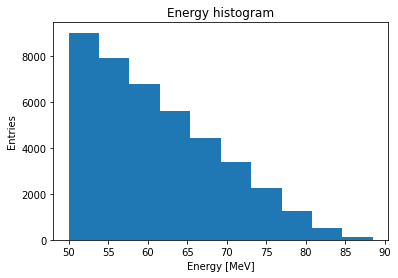

In [ ]:
plt.hist(signal_numpy_data[:, 0])
plt.xlabel("Energy [MeV]")
plt.ylabel("Entries")
plt.title("Energy histogram")

Text(0.5, 1.0, 'Time histogram')

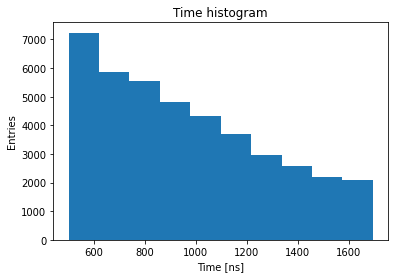

In [ ]:
plt.hist(signal_numpy_data[:, 1])
plt.xlabel("Time [ns]")
plt.ylabel("Entries")
plt.title("Time histogram")

Text(0.5, 1.0, 'Radius histogram')

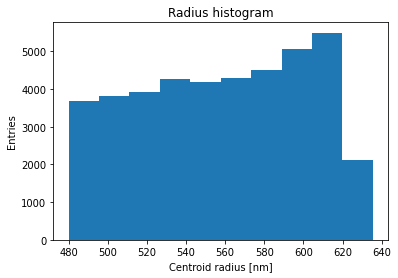

In [ ]:
plt.hist(signal_numpy_data[:, 2])
plt.xlabel("Centroid radius [nm]")
plt.ylabel("Entries")
plt.title("Radius histogram")

Text(0.5, 1.0, 'Active cells histogram')

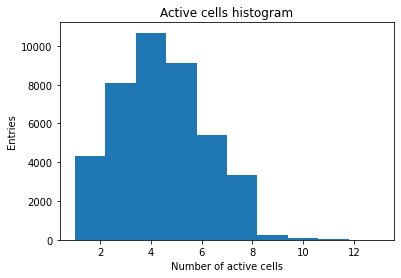

In [ ]:
plt.hist(signal_numpy_data[:, 3])
plt.xlabel("Number of active cells")
plt.ylabel("Entries")
plt.title("Active cells histogram")

In [ ]:
#concatenazione di segnale e bkg in un singolo array, X, quello coi dati
#Features array
X = np.concatenate((signal_numpy_data, bkg_numpy_data))

#crea array con le label: 1 per tutti gli eventi di segnale (un array di uni tanti quanto è lungo signal_numpy_data) 
# e 0 per bkg 

Y = np.concatenate((np.ones(len(signal_numpy_data)), np.zeros(len(bkg_numpy_data))))

#pesi
signal_weight = 330/150e3 * 100
mnbs_weight = 1.3/5.25 * 100

#array di pesi

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

train_to_test_ratio = 0.7

X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(
    X, Y, W,
    train_size = train_to_test_ratio,
    test_size = 1.0 - train_to_test_ratio
)

X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(
    X_train, Y_train, W_train,
    train_size = train_to_test_ratio,
    test_size = 1.0 - train_to_test_ratio
)
W = np.concatenate([ np.ones((len(signal_numpy_data)))*signal_weight, np.ones((len(bkg_numpy_data)))*mnbs_weight ])


X shape: (42504, 4)
Y shape: (42504,)


In [ ]:
#Package to make nicer plots
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.7-py3-none-any.whl size=68151 sha256=edcb354e75ea72b66162dba8bb93daaf89378e1b5dcc79d20df474f736bf46ac
  Stored in directory: /root/.cache/pip/wheels/bf/ba/9f/87c689d8d3c2916793f2dccc57d3dc3b283e0ccf8cb4ca4cad
Successfully built dtreeviz


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AprC: 0.9160046197590996


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


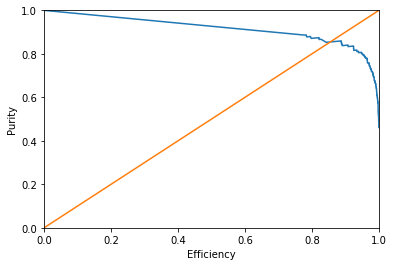

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AprC: 0.9251817522687874


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished


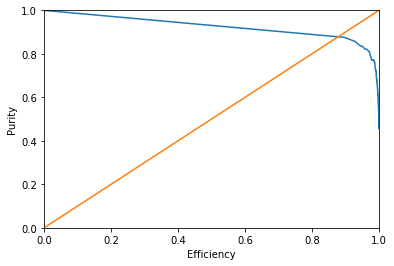

AprC: 0.9448566536628927


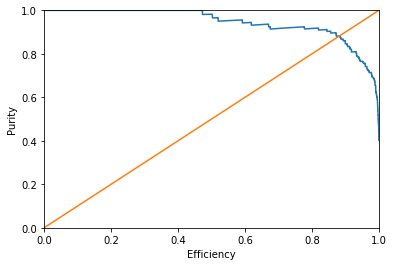

AprC: 0.9098882190147894


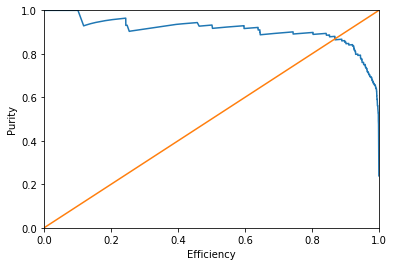

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont:

AprC: 0.8606800202931641


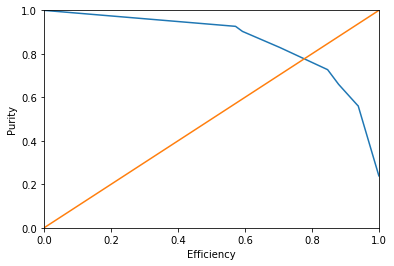

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from dtreeviz.trees import *

clf_dict = {
    RandomForestClassifier: dict(min_samples_split=10, n_estimators=200, warm_start=True, verbose=1),
    ExtraTreesClassifier: dict(n_estimators=200, verbose=1),
    AdaBoostClassifier: dict(n_estimators=200),
    HistGradientBoostingClassifier: dict(max_iter=200),
    DecisionTreeClassifier: dict(max_depth=3),
}

for clf in clf_dict:
  instance = clf(**clf_dict[clf])

  instance.fit(X_train, Y_train, sample_weight=W_train)

  probs = instance.predict_proba(X_test)[:, 1]

  if isinstance(instance, DecisionTreeClassifier):

    viz = dtreeviz(instance, X_test, Y_test,
                    target_name="target",
                    feature_names=["E", "T", "R", "C"],
                    class_names=["S", "B"] )

    viz.save("decision_tree.svg")

  prec, recall, thres = precision_recall_curve(Y_test, probs, sample_weight=W_test)
  print(f"AprC: {auc(recall, prec)}")
  plt.plot(recall, prec)
  plt.plot([0, 1], [0, 1])
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.ylabel("Purity")
  plt.xlabel("Efficiency")

  plt.show()


In [ ]:
#Uso XGBoost
time_start = time.time()
xg_train = xgb.DMatrix(X_train, label=Y_train, weight=W_train)
xg_test = xgb.DMatrix(X_test, label=Y_test, weight=W_test)
xg_val = xgb.DMatrix(X_val, label=Y_val, weight=W_val)

param = {
    # use softmax multi-class classification
    # scale weight of positive examples
    'objective': 'binary:logistic',
    'n_estimators': 20,
    'max_depth': 5,
    'silent': 0,
    'gpu_id': 0,
    #'max_bin': 6,
    'tree_method': 'gpu_hist',
    "eval_metric": [
      "aucpr",
    ]
}

# watchlist allows us to monitor the evaluation result on all data in the list 
watchlist = [(xg_train, 'train'), (xg_val, 'val')]
num_round = 50

bst = xgb.train(param, xg_train, num_round, watchlist)

print(time.time() - time_start)

[0]	train-aucpr:0.95625	val-aucpr:0.901817
[1]	train-aucpr:0.964162	val-aucpr:0.912222
[2]	train-aucpr:0.97837	val-aucpr:0.868555
[3]	train-aucpr:0.983467	val-aucpr:0.905333
[4]	train-aucpr:0.984351	val-aucpr:0.906549
[5]	train-aucpr:0.985856	val-aucpr:0.908827
[6]	train-aucpr:0.988492	val-aucpr:0.916337
[7]	train-aucpr:0.989362	val-aucpr:0.948565
[8]	train-aucpr:0.990337	val-aucpr:0.946474
[9]	train-aucpr:0.990995	val-aucpr:0.948497
[10]	train-aucpr:0.99224	val-aucpr:0.95062
[11]	train-aucpr:0.992573	val-aucpr:0.952622
[12]	train-aucpr:0.993331	val-aucpr:0.953043
[13]	train-aucpr:0.993756	val-aucpr:0.955213
[14]	train-aucpr:0.994602	val-aucpr:0.9548
[15]	train-aucpr:0.994912	val-aucpr:0.955056
[16]	train-aucpr:0.995299	val-aucpr:0.955249
[17]	train-aucpr:0.995462	val-aucpr:0.955905
[18]	train-aucpr:0.995924	val-aucpr:0.956522
[19]	train-aucpr:0.996133	val-aucpr:0.955493
[20]	train-aucpr:0.996334	val-aucpr:0.956252
[21]	train-aucpr:0.996477	val-aucpr:0.955679
[22]	train-aucpr:0.996658	

AUprC: 0.9294882263818509


Text(0, 0.5, 'Efficiency')

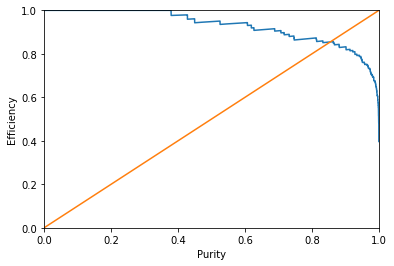

In [ ]:
probs = bst.predict(xg_test)

prec, recall, thres = precision_recall_curve(Y_test, probs, sample_weight=W_test)

print(f"AUprC: {auc(recall, prec)}")

plt.plot(recall, prec)
plt.plot([0, 1], [0, 1])

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Purity")
plt.ylabel("Efficiency")


In [ ]:
#@title Data visualization 
!wget https://www.dropbox.com/sh/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a?dl=1 -O keras_input.zip
!unzip keras_input.zip


--2022-08-09 15:55:00--  https://www.dropbox.com/sh/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a [following]
--2022-08-09 15:55:01--  https://www.dropbox.com/sh/dl/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca432bb38f00706501d8d48dbaf.dl.dropboxusercontent.com/zip_download_get/BOFB67o2SYmdc3746bfxUHlN4Np_bwI-zJ-GUtSFhzqk3eKuuU2fwtZwz7iNdvN_yC2nAwDK77pftn7mhlfvLTpW38Xx7CsiWpHtkIoAondhCQ?dl=1# [following]
--2022-08-09 15:55:01--  https://uca432bb38f00706501d8d48dbaf.dl.dropboxusercontent.com/zip_download_get/BOFB67o2SYmdc3746bfxUHlN4Np_bwI-zJ-GUtSFhzqk3eKuuU2fwtZwz7iNdvN_yC2nAwDK77pft

2


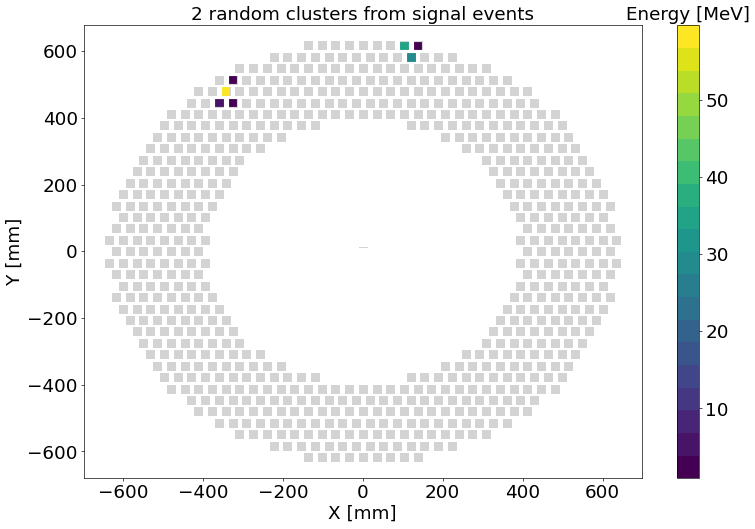

2


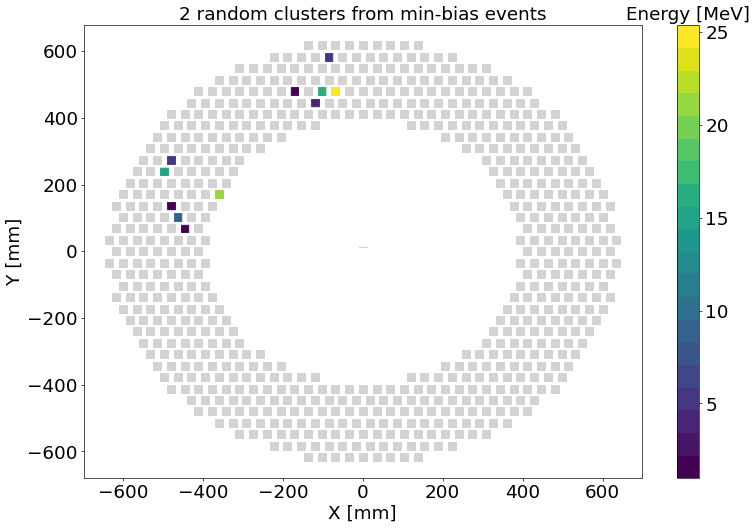

2


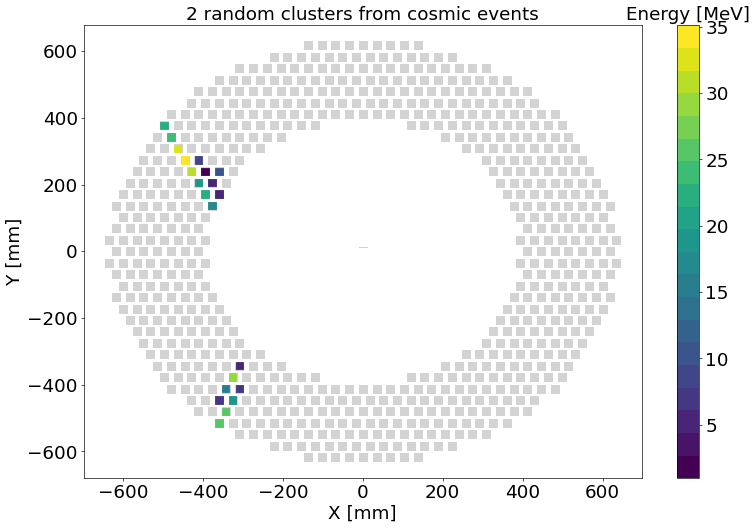

In [ ]:
name_map = {"points": "xy", "features": "et", "mask": "mask", "summary": "etrn"}

data_folder ="."
signal  = {key: np.load(f"{data_folder}/signal_{ name_map[key]}.npy") for key in name_map}

mnbs    = {key: np.load(f"{data_folder}/mnbs_{   name_map[key]}.npy") for key in name_map}

cosmics = {key: np.load(f"{data_folder}/cosmics_{name_map[key]}.npy") for key in name_map}

chs = [signal, mnbs, cosmics]
ch_names = ["signal", "min-bias", "cosmic"]

cmap = plt.get_cmap('viridis', 20)
cmap.set_under('white')

N = 2
for ch, name in zip(chs, ch_names):
  evs = np.random.randint(0, high=len(ch["points"]), size=N, dtype=int)
  print(len(evs))
  plt.figure(figsize=(15, 10), dpi=60)
  plt.scatter(cosmics["points"][:, :, 0], cosmics["points"][:, :, 1], marker="s", s=80, color="lightgrey")
  arr_xy = ch["points"][evs]
  x, y = arr_xy[:, :, 0], arr_xy[:, :, 1]
  e = ch["features"][evs][:, :, 0]
  plt.scatter(x, y, c=e, cmap=cmap, vmin=1, marker="s", s=80)
  plt.title(f"{N} random clusters from {name} events", fontsize=22)
  plt.xlabel("X [mm]", fontsize=22)
  plt.ylabel("Y [mm]", fontsize=22)
  plt.xticks(fontsize=22)
  plt.yticks(fontsize=22)
  clb = plt.colorbar()
  clb.ax.set_title('Energy [MeV]',fontsize=22)
  clb.ax.tick_params(labelsize=22)
  plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
X_train.shape

(20826, 4)

In [ ]:
#PROVA

import tensorflow as tf
from tensorflow import keras






In [ ]:
model = tf.keras.models.Sequential([
  #tf.keras.layers.Flatten(input_shape=(1, 4)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [ ]:
predictions = model(X_train[:1]).numpy()
predictions

array([[-140.55014 , -120.69133 ,   77.12886 ,  -72.17524 ,  -59.814598,
         -95.94801 , -101.579285, -177.9029  , -142.78336 , -113.64003 ]],
      dtype=float32)

In [ ]:
tf.nn.softmax(predictions).numpy()

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
loss_fn(Y_train[:1], predictions).numpy()

197.82019

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs=7)

Epoch 1/7
651/651 [==============================] - 2s 3ms/step - loss: 0.1387 - accuracy: 0.9704
Epoch 2/7
651/651 [==============================] - 3s 4ms/step - loss: 0.1262 - accuracy: 0.9713
Epoch 3/7
651/651 [==============================] - 2s 2ms/step - loss: 0.1288 - accuracy: 0.9722
Epoch 4/7
651/651 [==============================] - 2s 3ms/step - loss: 0.1170 - accuracy: 0.9721
Epoch 5/7
651/651 [==============================] - 1s 2ms/step - loss: 0.1136 - accuracy: 0.9730
Epoch 6/7
651/651 [==============================] - 1s 2ms/step - loss: 0.1121 - accuracy: 0.9727
Epoch 7/7
651/651 [==============================] - 1s 2ms/step - loss: 0.1057 - accuracy: 0.9734


In [ ]:
model.evaluate(X_val,  Y_val, verbose=2)

279/279 - 0s - loss: 0.0910 - accuracy: 0.9722 - 417ms/epoch - 1ms/step


[0.0909886583685875, 0.972216010093689]

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
probability_model(X_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[1.08653326e-02, 9.89134669e-01, 2.70113745e-28, 3.28201155e-18,
        4.23475366e-31, 6.39941031e-22, 3.24560333e-35, 3.76368062e-24,
        1.04241174e-26, 4.31697861e-37],
       [1.52073754e-02, 9.84792590e-01, 1.15953592e-25, 4.21037738e-16,
        5.91562701e-25, 1.05566146e-16, 8.11108044e-29, 2.69030940e-18,
        2.02410551e-21, 4.11778757e-32],
       [4.97433357e-03, 9.95025694e-01, 0.00000000e+00, 3.45023067e-29,
        0.00000000e+00, 1.92082848e-34, 0.00000000e+00, 4.63659950e-36,
        0.00000000e+00, 0.00000000e+00],
       [2.32010838e-02, 9.76798892e-01, 6.29802449e-26, 2.31969481e-15,
        1.08013633e-25, 7.53553994e-17, 1.16763611e-29, 7.93791415e-19,
        1.10745863e-21, 3.14862274e-32],
       [1.21046277e-02, 9.87895370e-01, 1.42304303e-28, 1.27279470e-18,
        3.13344359e-32, 4.87005299e-23, 5.99994766e-36, 4.69897719e-25,
        1.00879276e-27, 1.74366718e-37]], dtype=float32)>